# Changes in global_config.py

Change the following:
* 'prep_tile_id': 'UVU'
* 'prep_cloud_coverage_thresh': 20
* 'username'
* 'password'



# Field Mapping Code: Clustering Approach Demonstration Notebook

This notebook walks through the different processing steps necessary to load Sentinel-2 data (from raw zipped .SAFE files or from a prepared sample dataset) and analyze the imagery through two workflows: Clustering and Thresholding. The core functions are stored in the fields_functions.py file, which references a file with global parameters, the global_config.py file, that stores parameters in a dictionary. Refer to that file to see what each parameter controls. Changing parameters can be done interactively in this notebook by reassigning new values to the parameter, such as: `config['prep_file_dir'] = 'path/to/directory/with/sentinel/tiles/'` 

Since there are multiple ways to load and process data, this notebook should not be run sequentially in full. The first step is loading the data. This can be done by using the `prep_data()` function to load data from a directory of zipped .SAFE Sentinel-2 L2A tiles. Since these tiles are large (about 1 GB per tile), the data is not directly available with the code. In order to enable testing of the analysis code, we have provided a sample dataset as part of thie repo. To load that, run the cell under the "Load Sample Data" heading.

NOTE: In addition to the text description, most of the code is commented for clarity.

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Import packages

First, check the contents of the current working directory to make sure the python files with the functions and global parameters are accessible. Then, load import the fields_functions.py file. The config parameters are stored in the global_config.py, imported at the top of the fields_functions.py along with all the packages necessary for processing. 

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!conda --version

conda 23.3.1


In [ ]:
!conda install gdal

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.



In [ ]:
# Update pip
!python -m pip install -U pip
# Install scikit-image
!python -m pip install -U scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_image-0.20.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.2 MB)
  Using cached scipy-1.9.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.9 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.0
    Uninstalling scipy-1.10.0:
      Successfully uninstalled scipy-1.10.0
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


In [ ]:
!pip install -r /content/drive/MyDrive/omdena-poland/task-1-dataset/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_image-0.19.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.0 MB)
  Using cached scipy-1.10.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.1
    Uninstalling scipy-1.9.1:
      Successfully uninstalled scipy-1.9.1
  Attempting uninstall: scikit_image
    Found existing installation: scikit-image 0.20.0
    Uninstalling scikit-image-0.20.0:
      Successfully uninstalled scikit-image-0.20.0


In [ ]:
import os
from glob import glob
from pprint import pprint
%matplotlib inline

cwd = os.getcwd()
print(cwd)

py_files = glob('/content/drive/MyDrive/omdena-poland/task-1-dataset/*.py')
print(py_files)

/content
['/content/drive/MyDrive/omdena-poland/task-1-dataset/fields_functions.py', '/content/drive/MyDrive/omdena-poland/task-1-dataset/global_config.py']


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/omdena-poland/task-1-dataset/')

In [ ]:
### Import fields functions
from fields_functions import *

### Packages for some plotting to view outputs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

## Connect to the Copernicus Hub API

We will not use the Graphical User Interface from the Copernicus Open Access Hub as we want something fully automated, so we will use the API instead.

We will use the SentinelAPI: https://sentinelsat.readthedocs.io/en/latest/api_overview.html

In [ ]:
#Enter your username and password
username = config["username"]
password = config['password']

api = SentinelAPI(username,password, "https://scihub.copernicus.eu/dhus")

Let's take a look at the config parameters. The prefix for each parameter refers to the step in the processing workflow that corresponds with the parameters. For more detail about what each parameter controls, refer to the global_config.py file

In [ ]:
### We can change a parameter in the config dictionary by assigning it directly as so:
config['prep_base_chunk'] = 500

print(config)

### Changing global parameters
You can update the config dictionary interactively, too. Here, we change the base chunk size parameter. We can do this with any of the paramters within our notebook so that we do not have to change the global_config.py file directly.

### Loading data

The prep_data() function expects the `'prep_data_dir'` parameter in the config dictionary to have zipped Sentinel-2 L2A tiles. L2A tiles have been preprocessed to estimate bottom of atmosphere pixel values, correcting for atmospheric aerosols. The metadata for L1C data is apparently structured differently and does not work with the GDAL function to read the tile info.

Alternative from the original EveryField repo that we will not use it was written: 
"If you do not have access to the full set of Sentinel-2 tiles, you can skip the prep_data() function call and load a sample of the data found in the google drive project folder here: https://drive.google.com/drive/folders/1n2tzO8I6EZQdkYzcB8L9omVsQDsb8eEh?usp=sharing

The sample data comes in four versions for an area in NW Minnesota from the T14TPT tile during the 2019 groing season: 500x500 pixels with and without cloud mask applied, and 1000x1000 pixel with and without cloud mask applied. 

To load the sample data, download the version of interest and fill in the sample_data_fp variable to point to where it is saved locally. Skip the next cell and run the cell to load the netCDF file directly into xarray. This should enable you to run the rest of the demo code."

In our case for Poland, we will use directly zipped Sentinel-2 L2A tiles and the prep_data() module right after.

### Download L2A tiles

Sentinel images (aka data cubes) are called tiles and can be downloaded directly from the Copernicus Hub. The only thing which is needed is a shapefile of Area of Interest (aoi) to find the corresponding tile. In our case, we are interested in the full country of Poland which is our aoi. Luckily a shapefile for Poland can be found here: https://www.eea.europa.eu/data-and-maps/data/eea-reference-grids-2/gis-files/poland-shapefile

For our purpose, we will use the shapefile where the Poland area is devided in 10km squares area as illustrated below:

![pl_10km](pl_10km.png)

It is not perfect and we may need to remove squares which are 100% sea and which do not belong to Poland but the neigbhour countries.

In this demo, we will work only with one random selected square from this grid. As we do not know which squares are land or sea, we will first visualize the random selected square first. If it is land, we will use a seed to fix it for the demo, if it is sea we run the random selection again until we find land.

In [ ]:
# Plot the shapefile
poly = gpd.read_file("/content/drive/MyDrive/omdena-poland/task-1-dataset/pl_10km.shp") # previously "POLYGON.shp"
fig, ax = plt.subplots(figsize=(6, 6))

poly.plot(ax=ax)

ax.set_title("Poly",
             fontsize=16)
plt.show()

In [ ]:
# Load shape file
shapefile_all = gpd.read_file("/content/drive/MyDrive/omdena-poland/task-1-dataset/pl_10km.shp")
# Explore:
print(shapefile_all.head())
print(shapefile_all.crs)

The coordinate system is epsg:3035 and will need to be converted it to epsg:4326 for the SentinelAPI call. We also need to convert the shapefile to GeoJSON.

In [ ]:
# change CRS to epsg 4326
shapefile_all_transformed = shapefile_all.to_crs(epsg=4326)
print(shapefile_all_transformed.head())
print(shapefile_all_transformed.crs)

Now let's select one random square of land aoi for the future call to the SentinelAPI:

In [ ]:
# select a random square for demo (I ran it twice and found a land square aoi so I fixed the seed for the demo)
from random import seed, randrange
seed(105)
#rowid = randrange(0,shapefile_all_transformed.shape[0])
rowid = 177
shapefile = shapefile_all_transformed.iloc[[rowid]]
# Explore:
print(shapefile.head())

In [ ]:
# check that the conversion worked
shapefile.crs

In [ ]:
# Convert shapefile to GeoJSON as this is the format needed for the api
shapefile.to_file('POLYGON_POL_converted.geojson', driver='GeoJSON')

In [ ]:
# Define the path to your AOI - Must be a Geojson shapefile
footprint = geojson_to_wkt(read_geojson("POLYGON_POL_converted.geojson"))
print(footprint)

To be sure that we have a squre on land, lets plot it with folium, we need first to give the longitude and latitude where the map should be centered to show our square of interest. We will take the first coordinate:

In [ ]:
#for index, row in shapefile.iterrows():
#     for pt in list(row['geometry'].exterior.coords):
#        long = Point(pt).x
#        lat = Point(pt).y
#        print(long,lat)
#        break

In [ ]:
# Interactive visualization of polygon using the library folium
long, lat = 14.77941841, 52.67745247 # hard coded
m = folium.Map([lat, long], zoom_start=11) # starting coordinate: latitude and longitude of Lubola, Poland
boundary = gpd.read_file(r'POLYGON_POL_converted.geojson')
folium.GeoJson(boundary).add_to(m)
m

The aoi is land, we are good to go with the API.

In [ ]:
prep_cloud_coverage_thresh = config["prep_cloud_coverage_thresh"]
print(prep_cloud_coverage_thresh)

In [ ]:
# Define the sentinel products we need
# Not too much data to start as we will download it locally and those images are massive in size (will take disk space and time to download)
# Here we will be looking with a Descending orbit direction from May to October 2022 (harvest months) Sentinel-2 Hyperspectral (Level-2A) with any cloud coverage for now.
start_date = '20180501'
stop_date = '20181031'
products = api.query(footprint,
                     date = (start_date,stop_date),
                     platformname='Sentinel-2',
                     processinglevel = 'Level-2A',
                     orbitdirection='DESCENDING',
                     cloudcoverpercentage=(0, prep_cloud_coverage_thresh))
# Download all products 
gdf = api.to_geodataframe(products)
gdf.head(3)

In [ ]:
gdf.columns

In [ ]:
# create some new columns wiht the tileidentifier (5 letter and number), the month and the date seperately
def extract_tileID(x):
    return x[5]
    
gdf['tileidentifier'] = gdf['title'].str.split("_").apply(extract_tileID)
gdf['generationdateonly'] = pd.DatetimeIndex(gdf['beginposition']).date
gdf['generationmonthonly'] = pd.DatetimeIndex(gdf['beginposition']).month

# sort with less cloud coverage possible
gdf_sorted = gdf.sort_values(['tileidentifier', 'beginposition', 'cloudcoverpercentage'], ascending=[True,True,True])

gdf_sorted.head(3)

In [ ]:
# check that we have the 6 harvest month for at least one tile
gdf_sorted.groupby(['tileidentifier','generationmonthonly','cloudcoverpercentage']).count()

In [ ]:
# In the case we have several tile in the product package, we take only the first one.
gdf_sorted_head = gdf_sorted.groupby(['tileidentifier','generationmonthonly']).head(1)
gdf_sorted_head.head(6)

In [ ]:
print(gdf_sorted_head.shape)

In [ ]:
# WARNING ensure you have enough disk space for this demo. In my case it took 37.6 GB after a few tests.
# This will download N tiles of 6 months for tile id = T34UEB (see = 105) for the aoi of interest (not automated yet for checking if we have really the 6 months).
# Sometimes, the API is unable to download all the tiles, so we skip the failed download for now or trigger a Long Term Archive (LTA).
# Copernicus Open Access Hub no longer stores all products online for immediate retrieval. 
# Offline products can be requested from the Long Term Archive (LTA) and should become available within 24 hours
# Re-run the cell after 24 hours and the download in the archive will occur.
# Copernicus Open Access Hub’s quota currently permits users to request an offline product every 30 minutes.
from sentinelsat import LTAError
prep_file_dir = config['prep_file_dir']
prep_file_dir = '/content/drive/MyDrive/omdena-poland/data' #overwrite condig file
Path(prep_file_dir).mkdir(exist_ok=True)
for item in gdf_sorted["uuid"]:
    corresponding_title = gdf_sorted.loc[[item]]['title']
    corresponding_title_zip = corresponding_title.values[0] + ".zip"
    print("corresponding_title_zip",corresponding_title_zip)
    path_file = os.path.join(prep_file_dir, corresponding_title_zip)
    if path.exists(path_file):
        print("file already exits", corresponding_title_zip)
    else:
        product_info = api.get_product_odata(item)
        is_online = api.is_online(item)

        if is_online:
            print(f'Product {item} is online. Starting download.')
            try:
                api.download(item, directory_path= prep_file_dir)
            except:
                print(item, "issue during download. Skip.")
                pass
        else:
            print(f'Product {item} is not online. Triggered Archive Retrieval. Info: Offline products retrieval quota 20 max per 12H.')
            try:
                api.trigger_offline_retrieval(item)
            except LTAError:
                print(item, "retrieval quota 20 max per 12H reached. Skip.")
                pass
            except:
                print(item, "issue during trigger_offline_retrieval call. Skip.")
                pass

# Loading data from a directory of zipped Sentinel-2 files and prep the data

In [ ]:
### Loading data from a directory of zipped Sentinel-2 files
### Skip this step if you do not have a directory with Sentinel-2 tiles in it 
### Load the sample data in the cell below instead.

ds_time_stack = prep_data()

Cloud Coverage Threshold: 20
v {'tile_id': 'T33UVU', 'date_str': '20180608', 'date_obj': datetime.datetime(2018, 6, 8, 0, 0), 'gdal_str': 'SENTINEL2_L2A:/vsizip/S2A_MSIL2A_20180608T101021_N0208_R022_T33UVU_20180608T131739.zip/S2A_MSIL2A_20180608T101021_N0208_R022_T33UVU_20180608T131739.SAFE/MTD_MSIL2A.xml:10m:EPSG_32633', 'epsg': 'EPSG_32633', 'cloud_coverage': 0.139558, 'nodata_pixel_percentage': 0.0, 'platform': 'S2A', 'product_level': 'L2A', 'cloud_mask_str': '/vsizip/S2A_MSIL2A_20180608T101021_N0208_R022_T33UVU_20180608T131739.zip/S2A_MSIL2A_20180608T101021_N0208_R022_T33UVU_20180608T131739.SAFE/GRANULE/L2A_T33UVU_A015463_20180608T101024/QI_DATA/MSK_CLDPRB_20m.jp2'}
passed cloud coverage: 2018 06 08 with 0.139558 pct | nodata pixel pct: 0.0
v {'tile_id': 'T33UVU', 'date_str': '20180817', 'date_obj': datetime.datetime(2018, 8, 17, 0, 0), 'gdal_str': 'SENTINEL2_L2A:/vsizip/S2A_MSIL2A_20180817T101021_N0208_R022_T33UVU_20180817T150139.zip/S2A_MSIL2A_20180817T101021_N0208_R022_T33UVU_20

Should provide 10 tiles with cloud coverage below 20%. WARNING: Zero (0) tiles were available for the month of September below 20% cloud coverage.

### Loading sample data
Here, we will load the prepared sample data for a 500x500 pixel area by reading the netCDF file directly into an xarray dataset. This is the same as the prep_data() output but for a smaller spatial area. When we read in the data with `xr.open_dataset()` be sure to include the `chunks` argument to coerce the data into dask arrays, which enable parallel processing during the analysis steps. Here, we use the `'auto'` argument to allow xarray to automatically assign an appropriate chunk size to each of the three dimensions: x, y, and time.

In [ ]:
### Loading sample data directly from netCDF file
from google.colab import files
# filepath to the sample data
# sample_data_fp = 'C:/Users/jesse/Documents/grad school/masters research/code/fields_library/thesis_code_cleanup/sample_data/sample_data_TPT_px500_cldcov40_cldmask.nc'
#sample_data_fp = 'sample_data/sample_data_TPT_px500_cldcov40_cldmask.nc'


### In order to utilize parallel processing with dask within xarray, make sure to set a chunk size when reading in the data.
### You can use the keywork 'auto' to have dask automatically set a chunk size based on data size and memory limitations
#ds_time_stack = xr.open_dataset(sample_data_fp, chunks={'x':'auto', 'y':'auto','time':'auto'})
print(ds_time_stack)

<xarray.Dataset>
Dimensions:  (y: 500, x: 500, time: 10)
Coordinates:
  * y        (y) float64 5.825e+06 5.825e+06 5.825e+06 ... 5.82e+06 5.82e+06
  * x        (x) float64 4.75e+05 4.75e+05 4.75e+05 ... 4.799e+05 4.8e+05
  * time     (time) datetime64[ns] 2018-05-04 2018-05-14 ... 2018-10-21
Data variables:
    red      (time, y, x) float64 dask.array<chunksize=(10, 500, 500), meta=np.ndarray>
    green    (time, y, x) float64 dask.array<chunksize=(10, 500, 500), meta=np.ndarray>
    blue     (time, y, x) float64 dask.array<chunksize=(10, 500, 500), meta=np.ndarray>
    nir      (time, y, x) float64 dask.array<chunksize=(10, 500, 500), meta=np.ndarray>
Attributes:
    transform:     (10.0, 0.0, 399960.0, 0.0, -10.0, 5900040.0)
    crs:           +init=epsg:32633
    res:           (10.0, 10.0)
    is_tiled:      1
    nodatavals:    (nan, nan, nan, nan)
    scales:        (1.0, 1.0, 1.0, 1.0)
    offsets:       (0.0, 0.0, 0.0, 0.0)
    descriptions:  ('B4, central wavelength 665 nm', '

### Visualize one or several from the imagery

Let's take a look at the NIR band from one of the time steps in our raster stack. We named this object `ds_time_stack` because it is an xarray Dataset (ds) structure comprised of a stack of 4-band raster imagery across the time period of our study (May - October, 20XX). We can use some built-in xarray methods to select the time based on an index value in the time dimension `.isel(time=8)` and select the NIR band via the data variable name `.nir` and then use the `.plot()` method to visualize the band via a matplotlib wrapper function.

Need to create a xarray with coordinates to convert into a RGB image to feed the segmentation algorithm:

(500, 500, 3)
<xarray.DataArray 'red' (y: 500, x: 500, band: 3)>
dask.array<transpose, shape=(500, 500, 3), dtype=int64, chunksize=(500, 500, 1), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 5.825e+06 5.825e+06 5.825e+06 ... 5.82e+06 5.82e+06
  * x        (x) float64 4.75e+05 4.75e+05 4.75e+05 ... 4.799e+05 4.8e+05
    time     datetime64[ns] 2018-10-06
  * band     (band) <U1 'r' 'g' 'b'


(-0.5, 499.5, 499.5, -0.5)

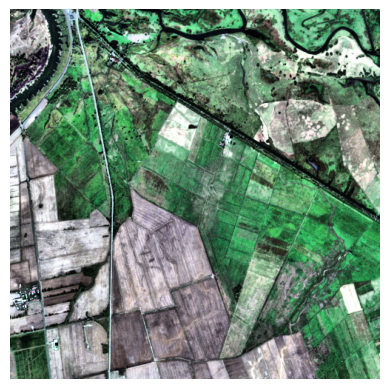

In [ ]:
# Create RGB from ds_time_stack for one month

date_index = 8 # choose one random  date only

rgb_da = clip_nan_ufunc(xr.concat([ds_time_stack.red.isel(time=date_index),
                                   ds_time_stack.green.isel(time=date_index),
                                   ds_time_stack.blue.isel(time=date_index)], dim='band'), percentile=1)
rgb_da = rgb_da.assign_coords(band=['r','g','b'])

### Transpose to (y, x, band) 
rgb_da = rgb_da.transpose('y', 'x', 'band')
print(rgb_da.shape)
print(rgb_da)

# Visualization
plt.imshow(exposure.equalize_adapthist(rgb_da.values,clip_limit=0.01))
plt.axis('off')
#plt.savefig("rgb_test.png", bbox_inches='tight', pad_inches = 0)

In [ ]:
# Convert xarray to numpy and check the form
rgb_da_numpy = rgb_da.to_numpy()
print(type(rgb_da_numpy))
print(rgb_da_numpy.shape)
print(rgb_da_numpy)

<class 'numpy.ndarray'>
(500, 500, 3)
[[[0.31303848 0.32274678 0.30188679]
  [0.37909248 0.42403433 0.40288568]
  [0.4704193  0.5416309  0.40288568]
  ...
  [0.1774842  0.37424893 0.24084351]
  [0.2303274  0.42403433 0.31742508]
  [0.29523262 0.54506438 0.38623751]]

 [[0.26536473 0.28240343 0.28967814]
  [0.29063756 0.31845494 0.27857936]
  [0.36243538 0.34248927 0.36514983]
  ...
  [0.13785181 0.29012876 0.17980022]
  [0.18150488 0.31502146 0.21531632]
  [0.23262493 0.42403433 0.3518313 ]]

 [[0.26421597 0.26609442 0.2563818 ]
  [0.17633544 0.1167382  0.17647059]
  [0.20964963 0.19914163 0.25083241]
  ...
  [0.10453762 0.19227468 0.15649279]
  [0.11545089 0.22060086 0.15649279]
  [0.15221137 0.28755365 0.20310766]]

 ...

 [[0.2894888  0.36566524 0.35294118]
  [0.33831132 0.39570815 0.39289678]
  [0.36071223 0.41630901 0.40954495]
  ...
  [0.3222286  0.55107296 0.41287458]
  [0.37966686 0.53476395 0.45394007]
  [0.37966686 0.57339056 0.41176471]]

 [[0.32452613 0.37854077 0.3618202 ]

Issue: float, need to be converted to 0 to 255.

In [ ]:
# Is there nan values?
np.isnan(np.sum(rgb_da_numpy))

True

In [ ]:
# Checking NaN values are gone
new_rgb_da_numpy = np.nan_to_num(rgb_da_numpy)
np.isnan(np.sum(new_rgb_da_numpy))

False

In [ ]:
# Normalizing in the range 0 to 1.
rgb_da_numpy_norm = (new_rgb_da_numpy-np.min(new_rgb_da_numpy))/(np.max(new_rgb_da_numpy)-np.min(new_rgb_da_numpy))

#print(rgb_da_numpy_norm)

# Scaling from 0 to 255 for future images pixel values
rgb_da_numpy_norm*=255

#print(rgb_da_numpy_norm)

# convert to uint8 for image pixel value
rgb_da_numpy_converted = rgb_da_numpy_norm.astype(np.uint8)

#print(rgb_da_numpy_converted)

print(type(rgb_da_numpy_converted))
print(rgb_da_numpy_converted.shape)
image = rgb_da_numpy_converted

<class 'numpy.ndarray'>
(500, 500, 3)


In [ ]:
# Export the numpy array to a png
from PIL import Image as im

data = im.fromarray(rgb_da_numpy_converted)
data.save('/content/drive/MyDrive/omdena-poland/data/rgb_da_numpy_converted.png')

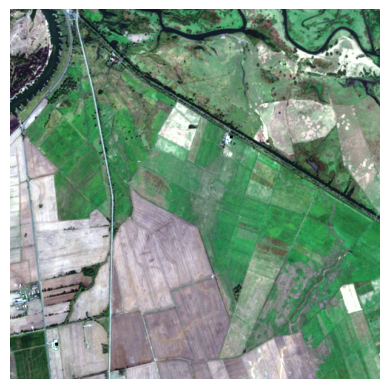

In [ ]:
# Visualization
import cv2
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# Read back the image
import cv2
image = cv2.imread('/content/drive/MyDrive/omdena-poland/data/rgb_da_numpy_converted.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(type(image))
print(image.shape)

<class 'numpy.ndarray'>
(500, 500, 3)


Checked: kept dimensions (500, 500, 3). Good to go to the segmentation notebook.

# Run notebook segment_seg_shared.ipynb

# Load the mask and extract mask

In [ ]:
masks = np.load('/content/drive/MyDrive/omdena-poland/data/masks.npy', allow_pickle=True)

In [ ]:
# List of dico
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 3114,
 'bbox': [373, 122, 66, 58],
 'predicted_iou': 1.0074363946914673,
 'point_coords': [[382.8125, 164.0625]],
 'stability_score': 0.9853596687316895,
 'crop_box': [0, 0, 500, 500]}

# WARNING: the part below is not done yet. It is not working. Work in progress.

In [ ]:
#rgb_da
w, h, d = rgb_da.shape

In [ ]:
def show_anns(anns):
  if len(anns) == 0:
    return
  sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
  #ax = plt.gca()
  #ax.set_autoscale_on(False)
  polygons = []
  color = []
  cnt = 0
  for ann in sorted_anns:
    m = ann['segmentation']
    img = np.ones((m.shape[0], m.shape[1], 3))
    color_mask = np.random.random((1, 3)).tolist()[0]
    #print(color_mask)
    for i in range(3):
      img[:,:,i] = color_mask[i]
    one_stack = np.dstack((img, m*0.35))
    if cnt == 0:
      all_stack = one_stack
    else:
      all_stack = np.dstack((one_stack, all_stack))
    #ax.imshow(np.dstack((img, m*0.35)))
  return all_stack

In [ ]:
all_stacked = show_anns(masks)
all_stacked.shape

(500, 500, 4)

In [ ]:
clustered_img_da = xr.DataArray(all_stacked[:,:,1],
                                dims=['y','x'],
                                coords={'x':rgb_da.coords['x'],
                                        'y':rgb_da.coords['y']})
clustered_img_da = clustered_img_da.chunk({'x': 'auto', 'y': 'auto'}).astype(int)

In [ ]:
clustered_img_da

<xarray.DataArray (y: 500, x: 500)>
dask.array<astype, shape=(500, 500), dtype=int64, chunksize=(500, 500), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 4.75e+05 4.75e+05 4.75e+05 ... 4.799e+05 4.8e+05
  * y        (y) float64 5.825e+06 5.825e+06 5.825e+06 ... 5.82e+06 5.82e+06

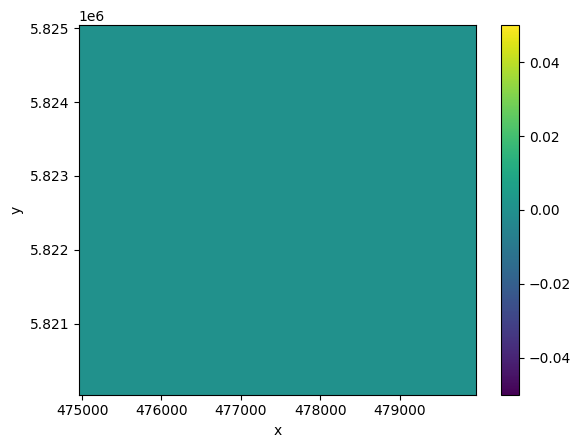

In [ ]:
clustered_img_da.plot()
#plt.axis('off')
#plt.savefig("test3.png", bbox_inches='tight', pad_inches = 0)